# Decision Tree, Random Forest

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline 
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve 

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
%load_ext autoreload
%autoreload 2
import pipeline_tree as pipeline_tree

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
NUMERIC_FEATURES = ['age','education','num_household','num_child',
                    'partner_edu','if_own_house','if_employment_current']
CATGORICAL_FEATURES = ['if_urban','wealth_index','if_earn_more','sex_head_household', 
              'partner_ideal_child','money_decide_person']
FEATURES = NUMERIC_FEATURES + CATGORICAL_FEATURES
TARGET_LST = ['if_emo_vio', 'if_phy_vio', 'if_sex_vio', 'if_vio']


In [ ]:
# Old Features

# FEATURES = ['province','age','education', 'if_urban',
#                  'wealth_index', 'if_own_house',
#                  'if_employment', 'if_employment_current','employment_pay_method', 'if_earn_more',
#                  'partner_edu', 
#                  'num_child','sex_head_household', 'sexual_activity', 'ideal_num_child', 'partner_ideal_child', 'money_decide_person']
# NUMERIC_FEATURES = ['age','education','if_own_house','if_employment_current','partner_edu','num_child','ideal_num_child']
# CATGORICAL_FEATURES = ['province', 'if_urban',
#                  'wealth_index',
#                  'if_employment','employment_pay_method','if_earn_more', 
#                  'sex_head_household', 'sexual_activity', 'partner_ideal_child', 'money_decide_person']
# TARGET_LST = ['if_emo_vio', 'if_phy_vio', 'if_sex_vio', 'if_vio']

In [5]:
FILES = ['cleaned_data/cambodia_2014_cleaned.csv', 
         'cleaned_data/Maldives_2016_cleaned.csv', 
         'cleaned_data/Nepal_2016_cleaned.csv',
         'cleaned_data/Pakistan_2017_cleaned.csv',
         'cleaned_data/Philippines_2017_cleaned.csv']
COUNTRY_DATA = {
    'Cambodia': 'cleaned_data/cambodia_2014_cleaned.csv', 
    'Maldives': 'cleaned_data/Maldives_2016_cleaned.csv', 
    'Nepal': 'cleaned_data/Nepal_2016_cleaned.csv',
    'Pakistan': 'cleaned_data/Pakistan_2017_cleaned.csv',
    'Philippines': 'cleaned_data/Philippines_2017_cleaned.csv'   
}

In [6]:
# Initialize results data frame
RESULT_MODEL = pd.DataFrame(columns = ('country','target','model','params','f1','accuracy','precision','recall','roc_auc','model_object'))

In [8]:
country_df_lst = []
for country, file in COUNTRY_DATA.items():
    df = pipeline_tree.read_data(file)
    country_df = pipeline_tree.one_country_model_all_tree(df, country, TARGET_LST, FEATURES, CATGORICAL_FEATURES, NUMERIC_FEATURES, RESULT_MODEL)
    
    country_df_lst.append(country_df)
RESULT_MODEL = pd.concat(country_df_lst)


 
 Target:  if_emo_vio 



 
 Target:  if_phy_vio 



 
 Target:  if_sex_vio 



 
 Target:  if_vio 



 
 Target:  if_emo_vio 



 
 Target:  if_phy_vio 



 
 Target:  if_sex_vio 



 
 Target:  if_vio 



 
 Country:  Cambodia 



 
 Target:  if_emo_vio 



 
 Target:  if_phy_vio 



 
 Target:  if_sex_vio 



 
 Target:  if_vio 



 
 Target:  if_emo_vio 



 
 Target:  if_phy_vio 



 
 Target:  if_sex_vio 



 
 Target:  if_vio 



 
 Target:  if_emo_vio 



 
 Target:  if_phy_vio 



 
 Target:  if_sex_vio 



 
 Target:  if_vio 



 
 Target:  if_emo_vio 



 
 Target:  if_phy_vio 



 
 Target:  if_sex_vio 



 
 Target:  if_vio 



 
 Target:  if_emo_vio 



 
 Target:  if_phy_vio 



 
 Target:  if_sex_vio 



 
 Target:  if_vio 



 
 Country:  Maldives 



 
 Target:  if_emo_vio 



 
 Target:  if_phy_vio 



 
 Target:  if_sex_vio 



 
 Target:  if_vio 



 
 Target:  if_emo_vio 



 
 Target:  if_phy_vio 



 
 Target:  if_sex_vio 



 
 Target:  if_vio 



 
 Target: 

TypeError: 

In [ ]:
pd.set_option('max_colwidth',500)
RESULT_MODEL.sort_values(by=['f1'], ascending=False).head(200)

In [9]:
# Save result to csv file
RESULT_MODEL.to_csv("result_model_trees.csv")

In [10]:
country_df_lst

[     country      target                 model  \
 0   Cambodia  if_emo_vio  BalancedRandomForest   
 1   Cambodia  if_emo_vio  BalancedRandomForest   
 2   Cambodia  if_emo_vio  BalancedRandomForest   
 3   Cambodia  if_emo_vio  BalancedRandomForest   
 4   Cambodia  if_emo_vio  BalancedRandomForest   
 ..       ...         ...                   ...   
 7   Cambodia      if_vio      GradientBoosting   
 8   Cambodia      if_vio      GradientBoosting   
 9   Cambodia      if_vio      GradientBoosting   
 10  Cambodia      if_vio      GradientBoosting   
 11  Cambodia      if_vio      GradientBoosting   
 
                                                params        f1  accuracy  \
 0   {'criterion': 'gini', 'max_depth': 5, 'min_sam...  0.411602  0.603574   
 1   {'criterion': 'gini', 'max_depth': 5, 'min_sam...  0.425365  0.615974   
 2   {'criterion': 'gini', 'max_depth': 10, 'min_sa...  0.427938  0.627999   
 3   {'criterion': 'gini', 'max_depth': 10, 'min_sa...  0.425690  0.620639

In [11]:
RESULT_MODEL = pd.concat(country_df_lst)

In [12]:
RESULT_MODEL.to_csv("result_model_trees.csv")

In [13]:
country = 'Philippines'
df = pipeline_tree.read_data('cleaned_data/Philippines_2017_cleaned.csv')
country_df = pipeline_tree.one_country_model_all_tree(df, country, TARGET_LST, FEATURES, CATGORICAL_FEATURES, NUMERIC_FEATURES, RESULT_MODEL)


 
 Target:  if_emo_vio 



 
 Target:  if_phy_vio 



 
 Target:  if_sex_vio 



 
 Target:  if_vio 



 
 Target:  if_emo_vio 



 
 Target:  if_phy_vio 



 
 Target:  if_sex_vio 



 
 Target:  if_vio 



 
 Country:  Philippines 



 
 Target:  if_emo_vio 



 
 Target:  if_phy_vio 



 
 Target:  if_sex_vio 



 
 Target:  if_vio 



 
 Target:  if_emo_vio 



 
 Target:  if_phy_vio 



 
 Target:  if_sex_vio 



 
 Target:  if_vio 



 
 Target:  if_emo_vio 




KeyboardInterrupt: 

In [15]:
result_model_prev = pipeline_tree.read_data('result_model_trees.csv')
RESULT_MODEL = pd.concat([result_model_prev, country_df])
RESULT_MODEL.to_csv("result_model_trees_4.csv")

### Balanced Random Forest, Weighted Random Forest

The data is imbalanced and Random Forest doesn't work well with imbalanced data and our results show that the F1 scores and recall scores are relatively low. To alleviate the problem, I will use Balanced Random Forest and Weighted Random Forest to get better predictions. [Chen et al (2004)](https://statistics.berkeley.edu/sites/default/files/tech-reports/666.pdf)

- The regular RF classifier tends to be biased towards the majority class, so the weighted random forest places a heavier penalty on misclassifying the minority class (i.e. the minority class is given a larger weight). The weights are used in the tree induction procedure (the splits) and in the terminal nodes (class determined by weighted majority vote).

## Merged Data of Five Countries

In [59]:
NUMERIC_FEATURES = ['age','education','num_household','num_child',
                    'partner_edu','if_own_house','if_employment_current']
CATGORICAL_FEATURES = ['country', 'if_urban','wealth_index','if_earn_more','sex_head_household', 
              'partner_ideal_child','money_decide_person']
FEATURES = NUMERIC_FEATURES + CATGORICAL_FEATURES
TARGET_LST = ['if_emo_vio', 'if_phy_vio', 'if_sex_vio', 'if_vio']

In [24]:
df = pipeline_tree.read_data('cleaned_data/five_countries_data.csv')
country = 'Five_countries'
five_country_df = pipeline_tree.one_country_model_all_tree(df, country, TARGET_LST, FEATURES, CATGORICAL_FEATURES, NUMERIC_FEATURES, RESULT_MODEL)


 
 Target:  if_emo_vio 



 
 Target:  if_phy_vio 



 
 Target:  if_sex_vio 



 
 Target:  if_vio 



 
 Target:  if_emo_vio 



 
 Target:  if_phy_vio 



 
 Target:  if_sex_vio 



 
 Target:  if_vio 



 
 Country:  Five_countries 



 
 Target:  if_emo_vio 



 
 Target:  if_phy_vio 



 
 Target:  if_sex_vio 



 
 Target:  if_vio 



 
 Target:  if_emo_vio 



 
 Target:  if_phy_vio 



 
 Target:  if_sex_vio 



 
 Target:  if_vio 




In [26]:
five_country_df.to_csv("result_model_trees_5combined.csv")

In [29]:
df['if_vio'].value_counts()

0.0    19627
1.0     6878
Name: if_vio, dtype: int64

# Best models for merged data

In [32]:
model_result_merged = pd.read_csv("model_result/result_model_trees_5combined.csv")
model_result_merged.head()

,Unnamed: 0,country,target,model,params,f1,accuracy,precision,recall,roc_auc
0,0,Five_countries,if_emo_vio,BalancedRandomForest,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.371472,0.609780,0.275631,0.569665,0.638826
1,1,Five_countries,if_emo_vio,BalancedRandomForest,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.367924,0.608412,0.273276,0.563139,0.638520
2,2,Five_countries,if_emo_vio,BalancedRandomForest,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.376925,0.601292,0.275699,0.595758,0.645666
3,3,Five_countries,if_emo_vio,BalancedRandomForest,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.376967,0.599263,0.275095,0.598786,0.646708
4,4,Five_countries,if_emo_vio,BalancedRandomForest,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.374482,0.592992,0.271800,0.602056,0.639343


In [56]:
# pd.set_option('max_colwidth',500)
# model_result_merged.groupby(['target', 'model']).agg({'f1':'max', 'params': 'first'})

In [63]:
idx = model_result_merged.groupby(['target', 'model'])['f1'].idxmax()
# model_result_merged.loc[idx, ['target','model', 'params', 'f1']]
best_models = model_result_merged.loc[idx,:]
best_models

,Unnamed: 0,country,target,model,params,f1,accuracy,precision,recall,roc_auc
10,10,Five_countries,if_emo_vio,BalancedRandomForest,"{'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 2}",0.377299,0.597142,0.274511,0.603222,0.640374
148,4,Five_countries,if_emo_vio,DecisionTree,"{'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 2}",0.186963,0.746227,0.268280,0.144005,0.556394
196,4,Five_countries,if_emo_vio,RandomForest,"{'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 10}",0.103048,0.788436,0.368897,0.059935,0.606760
49,1,Five_countries,if_emo_vio,WeightedRandomForest,"{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 10}",0.371050,0.608989,0.275877,0.568425,0.633164
15,3,Five_countries,if_phy_vio,BalancedRandomForest,"{'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5}",0.352684,0.682182,0.249363,0.602376,0.696114
161,5,Five_countries,if_phy_vio,DecisionTree,"{'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 5}",0.180415,0.813479,0.245792,0.142951,0.560868
208,4,Five_countries,if_phy_vio,RandomForest,"{'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 10}",0.112204,0.852763,0.423196,0.064918,0.650796
85,13,Five_countries,if_phy_vio,WeightedRandomForest,"{'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 10}",0.341763,0.685908,0.244687,0.567541,0.683374
33,9,Five_countries,if_sex_vio,BalancedRandomForest,"{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 5}",0.132123,0.638370,0.073642,0.642137,0.683633
172,4,Five_countries,if_sex_vio,DecisionTree,"{'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 2}",0.061265,0.929306,0.071312,0.054005,0.526037


In [67]:
add_lst = ['f1_test','accuracy_test','precision_test','recall_test','roc_auc_test','model_object']
for col in add_lst:
    best_models[col] = None

In [82]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import json
import ast

In [73]:
MODEL_DICT = {
    'BalancedRandomForest': BalancedRandomForestClassifier(),
    'WeightedRandomForest': RandomForestClassifier(),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier()
}

{'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 2}


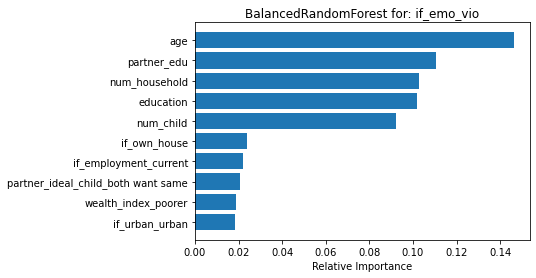

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 10}


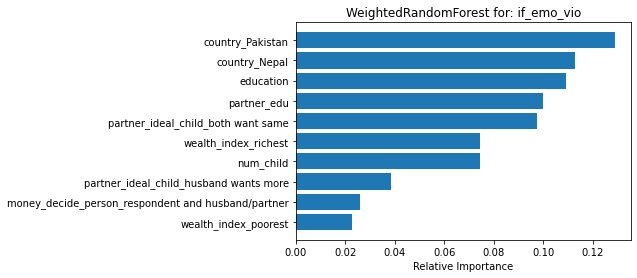

{'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5}


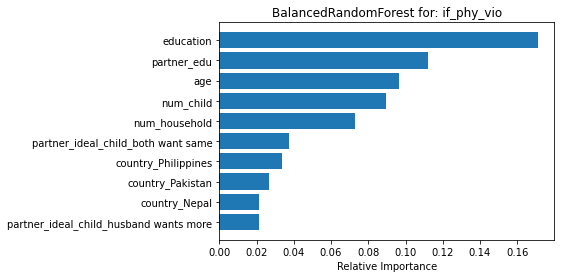

{'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 10}


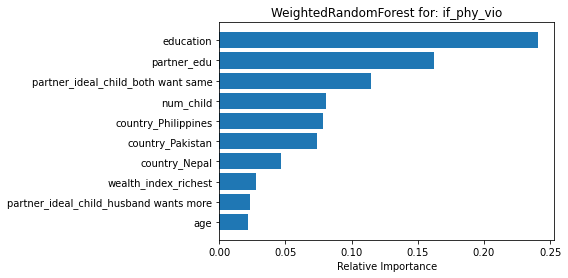

{'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5}


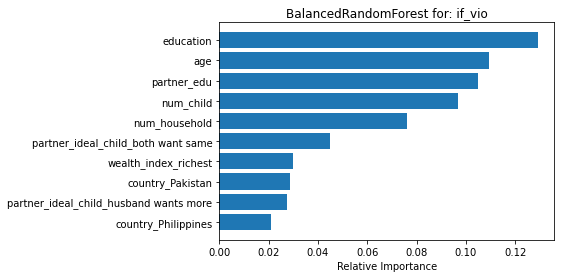

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 10}


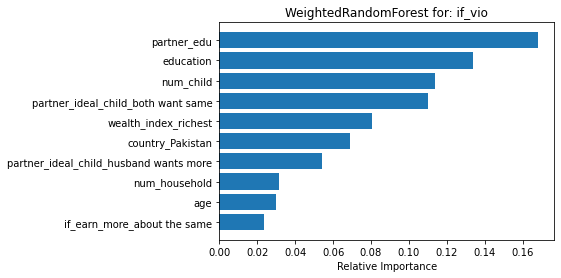

In [83]:
for i, row in best_models.iterrows():
    if row['f1'] > 0.3:
        target_col = row['target']
        model_name = row['model']
        params = ast.literal_eval(row['params'])
        print (params)
        model = MODEL_DICT[model_name]
        model.set_params(**params)
        features, target = pipeline_tree.preprocess_data(df, FEATURES, target_col, CATGORICAL_FEATURES)
        X_train, X_test, y_train, y_test = pipeline_tree.split_data(features, target, NUMERIC_FEATURES)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        pipeline_tree.plot_precision_recall_curve(model, X_test, y_test)
        best_models.at[i, 'f1_test'] = metrics.f1_score(y_test, y_pred)
        best_models.at[i, 'accuracy_test'] = metrics.accuracy_score(y_test, y_pred)
        best_models.at[i, 'precision_test'] = metrics.precision_score(y_test, y_pred)
        best_models.at[i, 'recall_test'] = metrics.recall_score(y_test, y_pred)
        best_models.at[i, 'roc_auc_test'] = metrics.roc_auc_score(y_test, y_pred)
        best_models.at[i, 'model_object'] = model
        title_str = model_name + ' for: ' + target_col
        pipeline_tree.plot_importances(model,X_train, n=10, title=title_str)

In [84]:
best_models

,Unnamed: 0,country,target,model,params,f1,accuracy,precision,recall,roc_auc,f1_test,accuracy_test,precision_test,recall_test,roc_auc_test,model_object
10,10,Five_countries,if_emo_vio,BalancedRandomForest,"{'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 2}",0.377299,0.597142,0.274511,0.603222,0.640374,0.379554,0.58555,0.277457,0.600536,0.591038,"(DecisionTreeClassifier(max_depth=10, max_features='auto', min_samples_split=5,\n random_state=1631267670), DecisionTreeClassifier(max_depth=10, max_features='auto', min_samples_split=5,\n random_state=1776353763), DecisionTreeClassifier(max_depth=10, max_features='auto', min_samples_split=5,\n random_state=360866051), DecisionTreeClassifier(max_depth=10, max_features='auto', min_samples_split=5,\n random..."
148,4,Five_countries,if_emo_vio,DecisionTree,"{'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 2}",0.186963,0.746227,0.268280,0.144005,0.556394,None,None,None,None,None,None
196,4,Five_countries,if_emo_vio,RandomForest,"{'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 10}",0.103048,0.788436,0.368897,0.059935,0.606760,None,None,None,None,None,None
49,1,Five_countries,if_emo_vio,WeightedRandomForest,"{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 10}",0.371050,0.608989,0.275877,0.568425,0.633164,0.35727,0.591398,0.267437,0.53798,0.571836,"(DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features='auto',\n min_samples_split=5, random_state=789414010), DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features='auto',\n min_samples_split=5, random_state=455748207), DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features='auto',\n min_samples_split=5, random_state=905540682), DecisionTreeClassifier(criterion='entropy', max_dep..."
15,3,Five_countries,if_phy_vio,BalancedRandomForest,"{'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5}",0.352684,0.682182,0.249363,0.602376,0.696114,0.3409,0.676853,0.242209,0.575325,0.634716,"(DecisionTreeClassifier(max_depth=10, max_features='auto', min_samples_split=5,\n random_state=1631267670), DecisionTreeClassifier(max_depth=10, max_features='auto', min_samples_split=5,\n random_state=1776353763), DecisionTreeClassifier(max_depth=10, max_features='auto', min_samples_split=5,\n random_state=360866051), DecisionTreeClassifier(max_depth=10, max_features='auto', min_samples_split=5,\n random..."
161,5,Five_countries,if_phy_vio,DecisionTree,"{'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 5}",0.180415,0.813479,0.245792,0.142951,0.560868,None,None,None,None,None,None
208,4,Five_countries,if_phy_vio,RandomForest,"{'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 10}",0.112204,0.852763,0.423196,0.064918,0.650796,None,None,None,None,None,None
85,13,Five_countries,if_phy_vio,WeightedRandomForest,"{'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 10}",0.341763,0.685908,0.244687,0.567541,0.683374,0.345711,0.710809,0.25747,0.525974,0.634097,"(DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features='auto',\n min_samples_split=5, random_state=789414010), DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features='auto',\n min_samples_split=5, random_state=455748207), DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features='auto',\n min_samples_split=5, random_state=905540682), DecisionTreeClassifier(criterion='entropy', max_dep..."
33,9,Five_countries,if_sex_vio,BalancedRandomForest,"{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 5}",0.132123,0.638370,0.073642,0.642137,0.683633,None,None,None,None,None,None
172,4,Five_countries,if_sex_vio,DecisionTree,"{'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 2}",0.061265,0.929306,0.071312,0.054005,0.526037,None,None,None,None,None,None


In [86]:
best_models.to_csv('model_result/best_model_test_result_tree_5combined')

# Best models for seperate countries

In [87]:
NUMERIC_FEATURES = ['age','education','num_household','num_child',
                    'partner_edu','if_own_house','if_employment_current']
CATGORICAL_FEATURES = ['if_urban','wealth_index','if_earn_more','sex_head_household', 
              'partner_ideal_child','money_decide_person']
FEATURES = NUMERIC_FEATURES + CATGORICAL_FEATURES
TARGET_LST = ['if_emo_vio', 'if_phy_vio', 'if_sex_vio', 'if_vio']

In [89]:
model_result_seperate = pd.read_csv("model_result/result_model_trees_5seperate.csv")
model_result_seperate.head()

,Unnamed: 0,country,target,model,params,f1,accuracy,precision,recall,roc_auc
0,0,Cambodia,if_emo_vio,BalancedRandomForest,"{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}",0.386655,0.575636,0.280058,0.625714,0.652600
1,1,Cambodia,if_emo_vio,BalancedRandomForest,"{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 5}",0.390714,0.573684,0.281862,0.638506,0.654279
2,2,Cambodia,if_emo_vio,BalancedRandomForest,"{'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}",0.398779,0.593488,0.292086,0.629513,0.646652
3,3,Cambodia,if_emo_vio,BalancedRandomForest,"{'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5}",0.398912,0.589217,0.290749,0.636656,0.647670
4,4,Cambodia,if_emo_vio,BalancedRandomForest,"{'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 2}",0.391442,0.594651,0.288926,0.607630,0.629165


In [92]:
idx = model_result_seperate.groupby(['country','target', 'model'])['f1'].idxmax()
# model_result_merged.loc[idx, ['target','model', 'params', 'f1']]
best_models = model_result_seperate.loc[idx,:]
best_models

,Unnamed: 0,country,target,model,params,f1,accuracy,precision,recall,roc_auc
7,7,Cambodia,if_emo_vio,BalancedRandomForest,"{'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 5}",0.402550,0.582618,0.290529,0.656558,0.649038
154,10,Cambodia,if_emo_vio,DecisionTree,"{'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 2}",0.272534,0.707512,0.293078,0.258669,0.549835
196,4,Cambodia,if_emo_vio,RandomForest,"{'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 10}",0.139517,0.761839,0.312111,0.090552,0.602046
60,12,Cambodia,if_emo_vio,WeightedRandomForest,"{'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 10}",0.398927,0.616777,0.301012,0.593344,0.640763
19,7,Cambodia,if_phy_vio,BalancedRandomForest,"{'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 5}",0.328339,0.603182,0.217077,0.675676,0.674364
...,...,...,...,...,...,...,...,...,...,...
1062,6,Philippines,if_sex_vio,WeightedRandomForest,"{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 10}",0.118583,0.731127,0.067767,0.475889,0.650280
1003,7,Philippines,if_vio,BalancedRandomForest,"{'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 5}",0.406124,0.543432,0.296248,0.647233,0.611608
1144,4,Philippines,if_vio,DecisionTree,"{'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 2}",0.213888,0.692891,0.279178,0.173934,0.540252
1192,4,Philippines,if_vio,RandomForest,"{'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 10}",0.095431,0.743610,0.319397,0.056306,0.565775


In [93]:
add_lst = ['f1_test','accuracy_test','precision_test','recall_test','roc_auc_test','model_object']
for col in add_lst:
    best_models[col] = None

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 5}


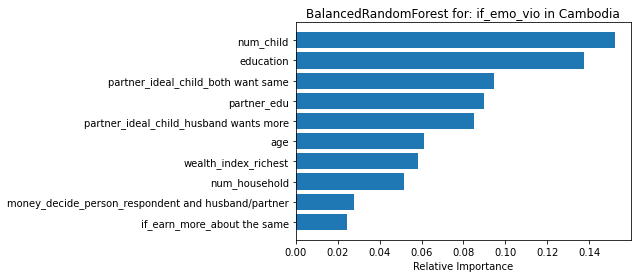

{'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 10}


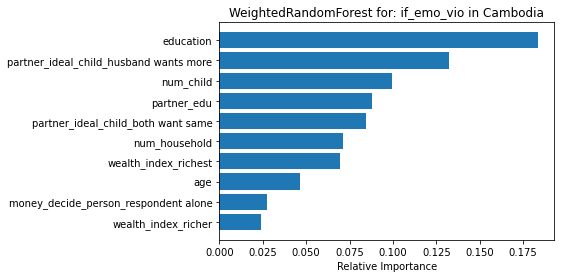

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 5}


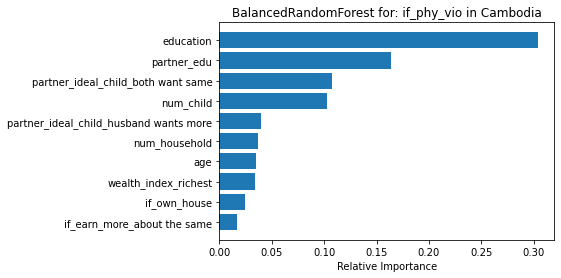

{'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 10}


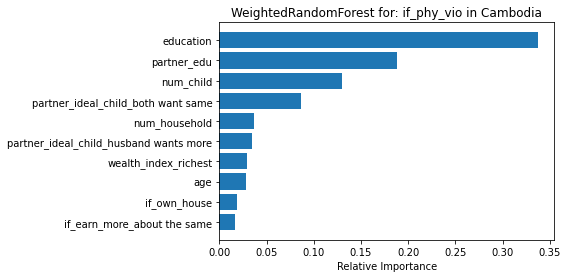

{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 5}


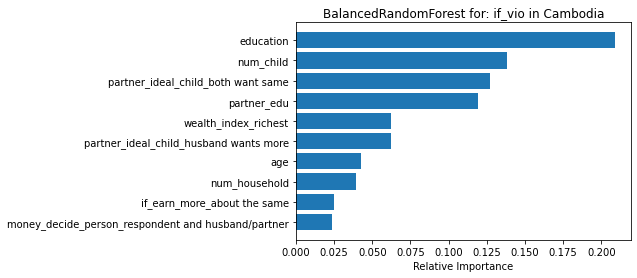

{'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 2}


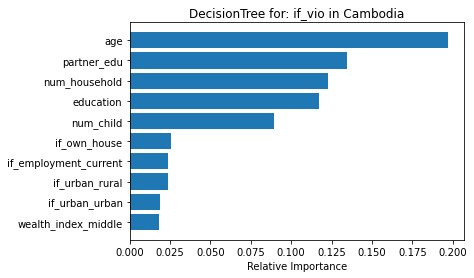

{'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 10}


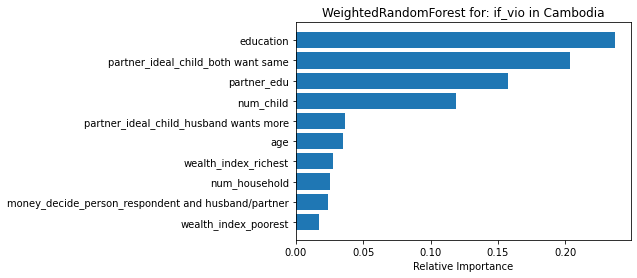

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2}


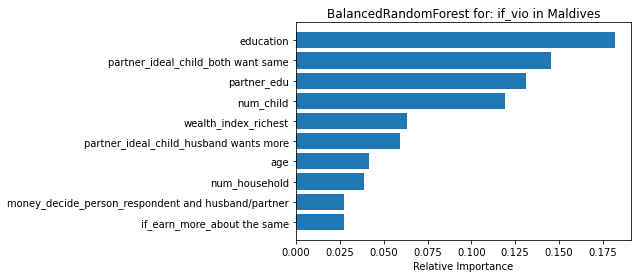

{'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 10}


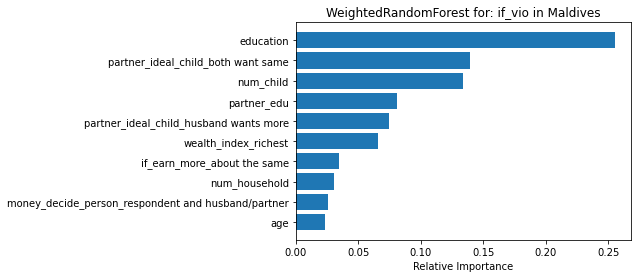

{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 5}


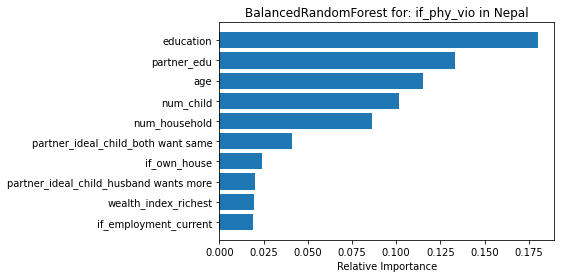

{'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 2}


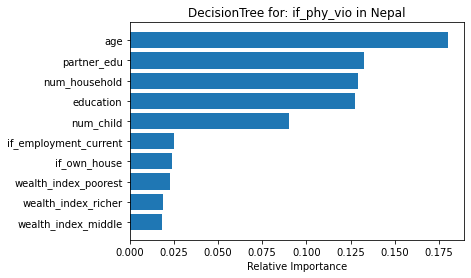

{'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 10}


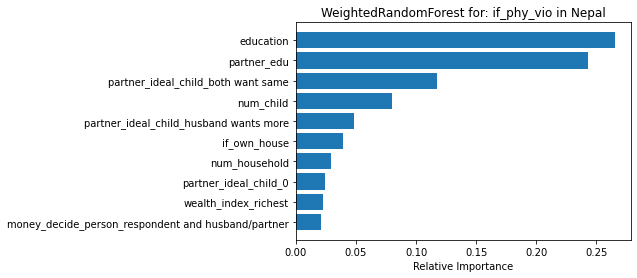

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 5}


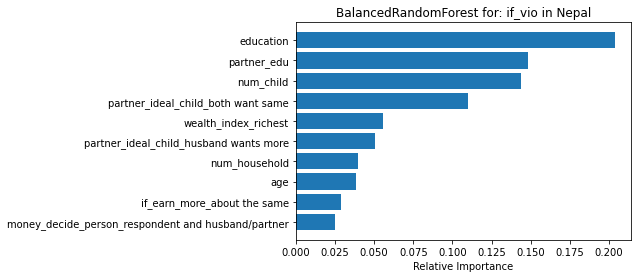

{'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 2}


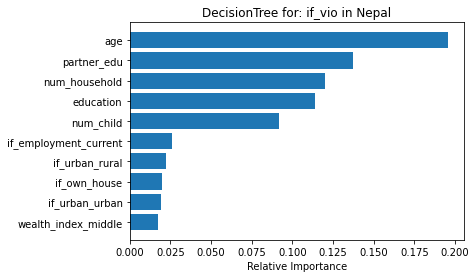

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 10}


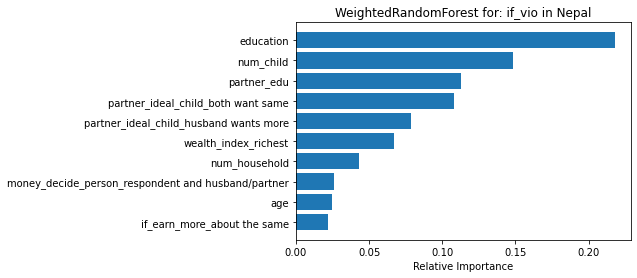

{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2}


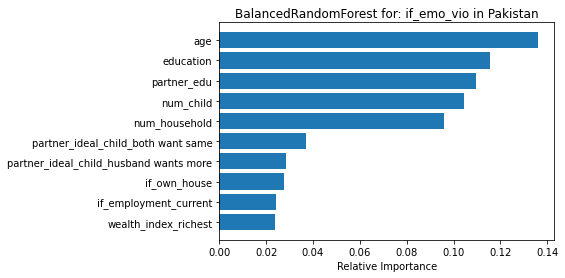

{'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 2}


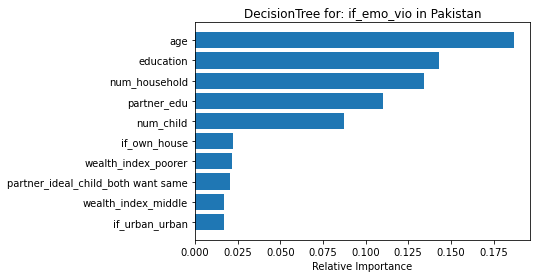

{'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 10}


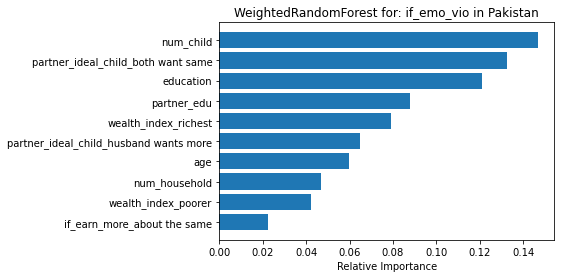

{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}


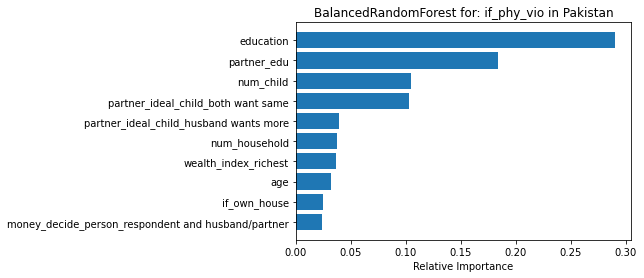

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 10}


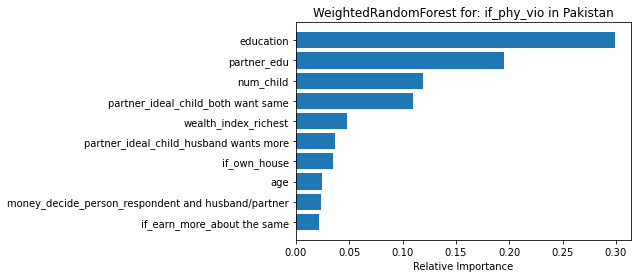

{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}


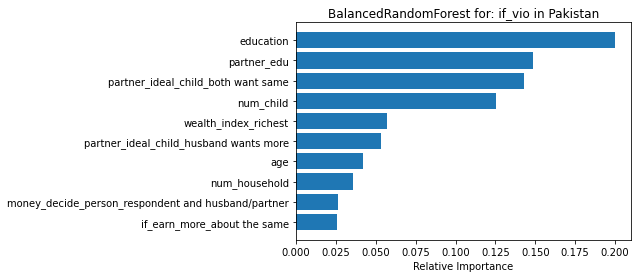

{'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 5}


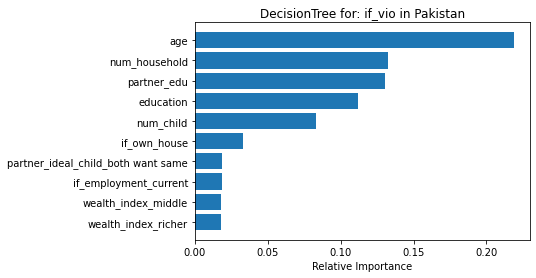

{'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 10}


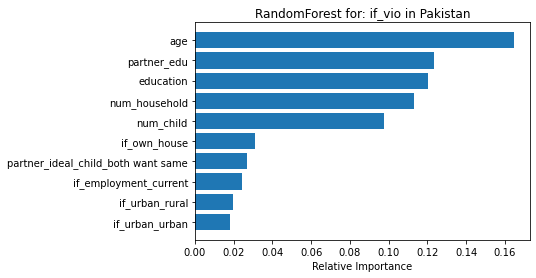

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 10}


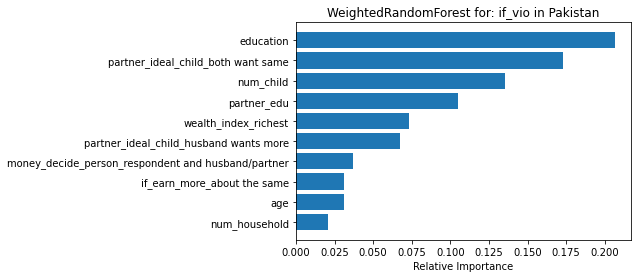

{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2}


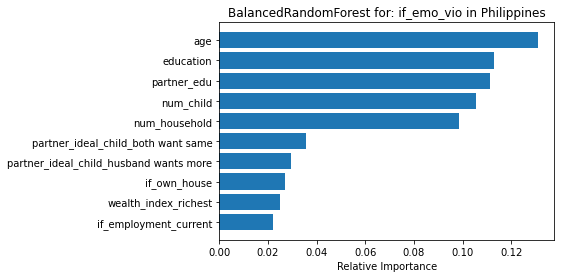

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 10}


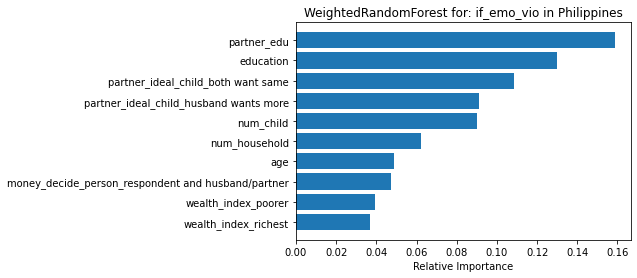

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 5}


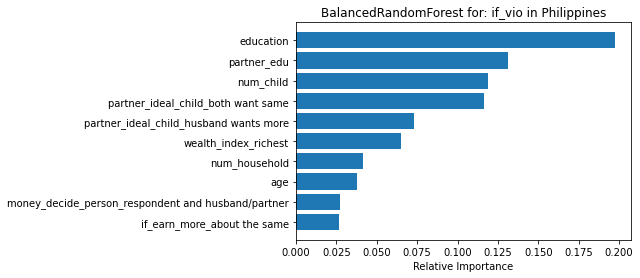

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 10}


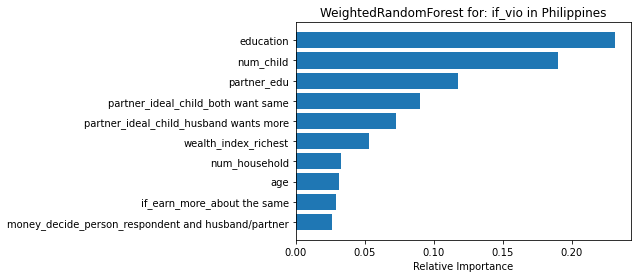

In [94]:
for i, row in best_models.iterrows():
    if row['f1'] > 0.3:
        country = row['country']
        target_col = row['target']
        model_name = row['model']
        params = ast.literal_eval(row['params'])
        print (params)
        model = MODEL_DICT[model_name]
        model.set_params(**params)
        features, target = pipeline_tree.preprocess_data(df, FEATURES, target_col, CATGORICAL_FEATURES)
        X_train, X_test, y_train, y_test = pipeline_tree.split_data(features, target, NUMERIC_FEATURES)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        pipeline_tree.plot_precision_recall_curve(model, X_test, y_test)
        best_models.at[i, 'f1_test'] = metrics.f1_score(y_test, y_pred)
        best_models.at[i, 'accuracy_test'] = metrics.accuracy_score(y_test, y_pred)
        best_models.at[i, 'precision_test'] = metrics.precision_score(y_test, y_pred)
        best_models.at[i, 'recall_test'] = metrics.recall_score(y_test, y_pred)
        best_models.at[i, 'roc_auc_test'] = metrics.roc_auc_score(y_test, y_pred)
        best_models.at[i, 'model_object'] = model
        title_str = model_name + ' for: ' + target_col + ' in ' + country
        pipeline_tree.plot_importances(model,X_train, n=10, title=title_str)

# Pipeline

In [7]:
# def split_data(features, target):
#     X_train, X_test, y_train, y_test = train_test_split(features, 
#                                                     target, 
#                                                     test_size=0.20, 
#                                                     random_state=505)
#     return X_train, X_test, y_train, y_test

In [8]:
# def preprocess_data(df, features_col, target_col, categorical_col):
#     df.dropna(subset=[target_col],inplace=True)
#     df = impute_missing_median(df, NUMERIC_FEATURES)
#     df = fill_categorical_na_vals(df)
#     features = df[features_col]
#     features = pd.get_dummies(features, columns=categorical_col)
#     target = df[target_col]
#     return features, target

In [9]:
# def impute_missing_median(df, col_lst):
#     '''
#     Impute missing values of continuous variables using the median value
#     '''
#     for col in col_lst:
#         df.loc[(df[col] == "don't know") | (df[col] == "non-numeric response") , col] = None
#         median = df[col].median()
#         df[col].fillna(median,inplace=True)
#     return df

In [10]:
# def fill_categorical_na_vals(df):
#     '''
#     Find colums and rows with missing values. Print rows, returns list of
#     columns.
#     '''
#     df = df.fillna(0)
#     return df

In [11]:
# def train_decision_tree(X_train, X_test, y_train, y_test):
#     params = {'criterion': ['gini', 'entropy'],
#                 'max_depth': [3,5,10,15],
#                 'min_samples_split': [2,5,10]}
#     grid_model = GridSearchCV(estimator=DecisionTreeClassifier(random_state=505), 
#                               param_grid=params, 
#                               cv=10,
#                               return_train_score=True,
#                               scoring=['f1', 'accuracy','precision','recall','roc_auc'],
#                               refit='f1')

#     grid_model.fit(X_train, y_train)
#     grid_result = pd.DataFrame(grid_model.cv_results_)
#     grid_result = grid_result[['params','mean_test_f1','mean_test_accuracy', 'mean_test_precision','mean_test_recall','mean_test_roc_auc']]
#     grid_result = grid_result.sort_values(by=['mean_test_f1'], ascending=False)
#     return grid_result
# #     print('Best model params: ', grid_result.loc[grid_result['mean_train_accuracy'] == max(grid_result['mean_train_accuracy'])]['params'])

In [12]:
# def train_random_forest(X_train, X_test, y_train, y_test):
#     params = {'n_estimators':[10, 100],
#               'criterion': ['gini', 'entropy'],
#               'max_depth': [3,5,10,15],
#               'min_samples_split': [2,5,10]}
#     grid_model = GridSearchCV(estimator=RandomForestClassifier(random_state=505), 
#                               param_grid=params, 
#                               cv=10,
#                               return_train_score=True,
#                               scoring=['f1', 'accuracy','precision','recall','roc_auc'],
#                               refit='f1')

#     grid_model.fit(X_train, y_train)
#     grid_result = pd.DataFrame(grid_model.cv_results_)
#     grid_result = grid_result[['params','mean_test_f1','mean_test_accuracy', 'mean_test_precision','mean_test_recall','mean_test_roc_auc']]
#     grid_result = grid_result.sort_values(by=['mean_test_f1'], ascending=False)
#     return grid_result


In [13]:
# def evaluate_test(model, X_test, y_test):
#     y_pred = model.predict(X_test)
#     plot_precision_recall_curve(model, X_test, y_test)
#     results_dict = {}
#     results_dict['f1'] = metrics.f1_score(y_test, y_pred)
#     results_dict['accuracy'] = metrics.accuracy_score(y_test, y_pred)
#     results_dict['precision'] = metrics.precision_score(y_test, y_pred)
#     results_dict['recall'] = metrics.recall_score(y_test, y_pred)
#     results_dict['roc_auc'] = metrics.roc_auc_score(y_test, y_pred)
#     plot_precision_recall_curve(model,X_test,y_test)    
#     return results_dict

In [14]:
# def plot_importances(model, X_train, n=10, title=''):
#     '''
#     Compute the relative importance of selected features in
#     the model
    
#     Inputs:
#     - model
#     - n (int): top n features, opt
#     - title (str)
#     '''
#     plt.close()
#     importances = model.feature_importances_
#     np_features = np.array(X_train.columns)
#     sorted_idx = np.argsort(importances)[len(np_features)-n:]
#     padding = np.arange(len(sorted_idx)) + 0.5
#     pl.barh(padding, importances[sorted_idx], align='center')
#     pl.yticks(padding, np_features[sorted_idx])
#     pl.xlabel("Relative Importance")
#     pl.title(title)
#     pl.show()

In [15]:
# def read_data(csv):
#     return pd.read_csv(csv)

In [ ]:
# df = pipeline_tree.read_data('cleaned_data/cambodia_2014_cleaned.csv')
# country = 'Cambodia'

In [ ]:
# RESULT_MODEL = pipeline_tree.one_country_model_decision_tree(df, country, TARGET_LST, FEATURES, CATGORICAL_FEATURES, NUMERIC_FEATURES, RESULT_MODEL)

In [ ]:
# RESULT_MODEL

In [ ]:
# RESULT_MODEL = pipeline_tree.one_country_model_random_forest(df, country, TARGET_LST, FEATURES, CATGORICAL_FEATURES, NUMERIC_FEATURES, RESULT_MODEL)

In [ ]:
# RESULT_MODEL = pipeline_tree.one_country_model_gradient_boosting(df, country, TARGET_LST, FEATURES, CATGORICAL_FEATURES, NUMERIC_FEATURES, RESULT_MODEL)

In [ ]:
# RESULT_MODEL

In [ ]:
# target_col = 'if_emo_vio'
# features, target = preprocess_data(df, FEATURES, target_col, CATGORICAL_FEATURES)
# X_train, X_test, y_train, y_test = split_data(features, target)
# grid_result= train_decision_tree(X_train, X_test, y_train, y_test)

In [ ]:
# grid_result.columns

In [ ]:
# pd.set_option('max_colwidth',500)

In [ ]:
# def one_country_model_decision_tree(df, TARGET_LST, FEATURES, CATGORICAL_FEATURES):
#     '''
#     Use decision tree to model data of one country
#     '''
#     for target_col in TARGET_LST:
#         print("\n \n Target: ", target_col, "\n\n")
#         features, target = preprocess_data(df, FEATURES, target_col, CATGORICAL_FEATURES)
#         X_train, X_test, y_train, y_test = split_data(features, target)
#         grid_result= train_decision_tree(X_train, X_test, y_train, y_test)
#         for params in grid_result['params'][:3]:
#             print('Params: ', params)
#             good_model = DecisionTreeClassifier(**params).fit(X_train, y_train)
#             result_dict = evaluate_test(good_model, X_test, y_test)
#             print(result_dict)
#             plot_importances(good_model, X_train, n=10, title= target_col + str(params))

In [ ]:
# one_country_model_decision_tree(df, TARGET_LST, FEATURES, CATGORICAL_FEATURES)

### Adjust Threshold
Since the recall score is low, we could try to adjust the classification threshold to improve the recall score.

In [ ]:
thresholds = [0.3, 0.35, 0.4, 0.45, 0.5]

In [ ]:
pred_prob = model.predict_proba(X_test)[:,1]
thresholds_result = pd.DataFrame(columns = ['Threshold', 'Precision', 'Recall'])
for thres in thresholds:
    y_pred = (pred_prob > thres)
    precision = precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    thres_dict = {}
    thres_dict['Threshold'] = thres
    thres_dict['Precision'] = precision
    thres_dict['Recall'] = recall
    thresholds_result = thresholds_result.append(thres_dict, ignore_index=True)   

[Reference: Decision Tree Ensembles- Bagging and Boosting](https://towardsdatascience.com/decision-tree-ensembles-bagging-and-boosting-266a8ba60fd9)